![](../JFM-notebooks-logo.jpg)

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

# Aesthetics
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper')
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='serif')

### Define first and second derivative operators to act on mean profiles

In [4]:
def ddx(A, x, BClo=0.0, BCup=0.0):
    """
    Computes the wall-normal derivative of the space(-time) data `A`
    which sits on the grid `x`. Upper and lower boundary values, at
    x=1 and x=0 respectively, can be set by the optional arguments
    `BCup` and `BClo`.
    """
    dA = np.zeros(A.shape)
    A = np.array(A)
    x = np.array(x)
    if dA.ndim==2:
        dA[0,:] = (A[1,:] - BClo)/x[1]
        dA[1:-1,:] = (A[2:,:] - A[:-2,:])/(x[2:] - x[:-2]).reshape(x.size-2,1)
        dA[-1,:] = (BCup - A[-2,:])/(1.0 - x[-2])
    elif dA.ndim==1:
        dA[0] = (A[1] - BClo)/x[1]
        dA[1:-1] = (A[2:] - A[:-2])/(x[2:] - x[:-2])
        dA[-1] = (BCup - A[-2])/(1.0 - x[-2])
    return dA

In [5]:
def d2x(A, x, Alo=0, Aup=0):
    D = np.zeros(A.shape)
    dp = x[2:] - x[1:-1]
    dm = x[1:-1] - x[:-2]
    D[1:-1] = ((A[2:] - A[1:-1])/dp - (A[1:-1] - A[:-2])/dm)*2/(dp + dm)
    # Use ghost cell at -x[0] for boundary calculation
    dp = x[1] - x[0]
    dm = 2*x[0]
    Am = 2*Alo - A[0]
    D[0] = ((A[1] - A[0])/dp - (A[0] - Am)/dm)*2/(dp + dm)
    dp = 2*(1.0 - x[-1])
    Ap = 2*Aup - A[-1]
    dm = x[-1] - x[-2]
    D[-1] = ((Ap - A[-1])/dp - (A[-1] - A[-2])/dm)*2/(dp + dm)
    return D

### Average profiles using anti-symmetry across the midplane

In [6]:
def asym_prof(v):
    n = v.size
    return 0.5*(v[:n//2] - v[-1:-n//2-1:-1])

In [7]:
def add_budget_plot(ax, grp, transparent=False):
    with h5py.File('../data/profile_record.h5','r') as fp:
        if grp in list(fp.keys()):
            x = fp[grp+'/xm'][:]
            xr = fp[grp+'/xmr'][:]
    
            vw = fp[grp+'/vxvy'][:]
            w = fp[grp+'/vybar'][:]
            T = -fp[grp+'/Sbar'][:]
    
            dyvw = ddx(vw, x)
            dyyw = d2x(w, x)
    
            lGr = int(grp[2])
            lRe = float(grp[-4:])
            nu = 10**(-lGr/2)
            Uf = 10**np.min([lGr/2 - lRe, 0])

            n = x.size
            nr = xr.size
            if transparent:
                al = 0.2
                ax.plot(xr[:nr//2], asym_prof(T), color="C0", alpha=al)
                ax.plot(x[:n//2], -asym_prof(dyvw)/Uf**2, color="C1", alpha=al)
                ax.plot(x[:n//2], nu*asym_prof(dyyw)/Uf, color="C2", alpha=al)
            else:
                ax.plot(xr[:nr//2], asym_prof(T), label="$g \\alpha \overline{\\theta}$", color="C0")
                ax.plot(x[:n//2], -asym_prof(dyvw)/Uf**2, label="$-\partial_y \overline{vw}$", color="C1")
                ax.plot(x[:n//2], nu*asym_prof(dyyw)/Uf, label="$\\nu \partial_{yy} \overline{w}$", color="C2")
        else:
            ax.set_visible(False)
    return

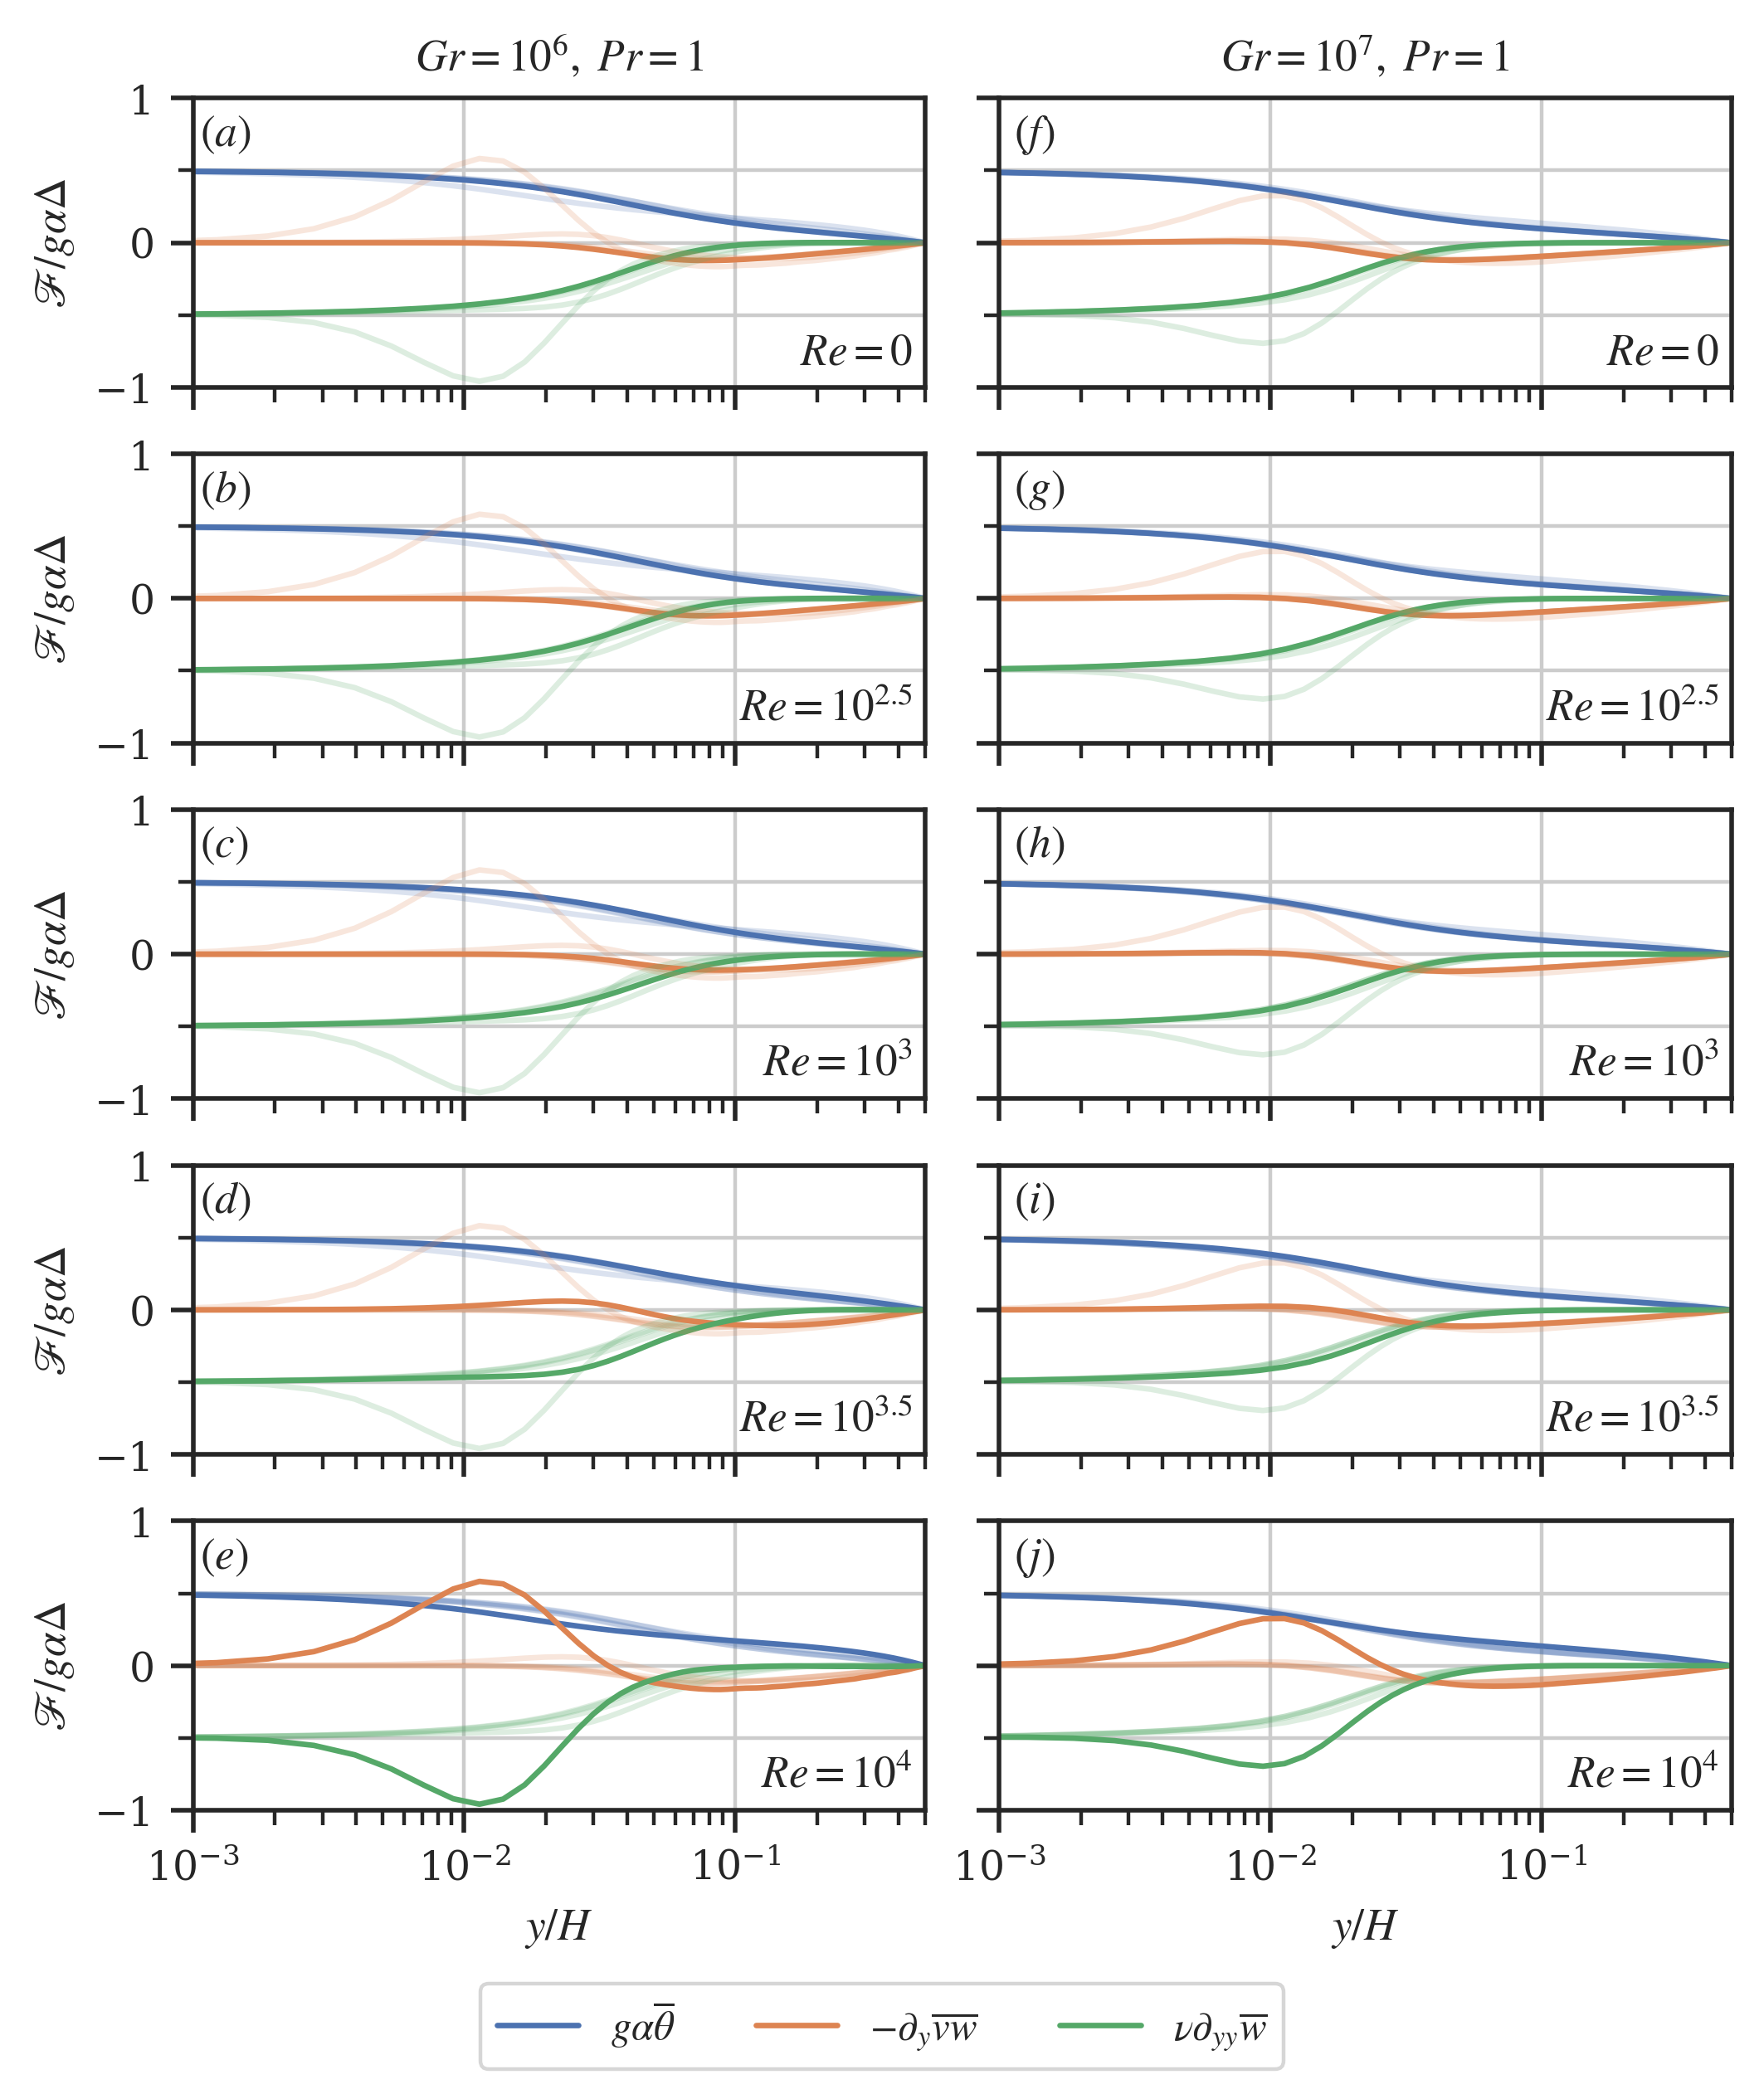

In [8]:
# List of log(Re) to plot
Res = [0, 2.5, 3, 3.5, 4]
Pr = 1
nR = len(Res)

fig, axs = plt.subplots(nR, 2, figsize=(5.2,6.2), sharex=True, sharey=True, dpi=200, layout='constrained')

# First column, Gr=10^6
lGr = 6
grps = ['Gr%i_Sc%i_Re%.2f' % (lGr, Pr, Re) for Re in Res]
for i in range(nR):
    for j in range(nR):
        trsp = (i!=j)
        add_budget_plot(axs[i,0], grps[j], transparent=trsp)

# Add labels
ax = axs[-1,0]
ax.semilogx()
ax.set_ylim([-1,1])
ax.set_xlabel('$y/H$')
for ax in axs.flatten():
    ax.set_yticks([-0.5,0.5], minor=True)
    ax.grid(True, which='both', axis='y')
    ax.grid(True, axis='x')
for ax in axs[:,0]:
    ax.set_ylabel('$\scrF/g\\alpha \Delta$')
axs[0,0].annotate('$Re=0$', (0.45, -0.9), ha='right', va='bottom')
for i in range(1,5):
    axs[i,0].annotate('$Re=10^{'+str(Res[i])+'}$', (0.45, -0.9), ha='right', va='bottom')
lbls = ['$('+lett+')$' for lett in ['a', 'b', 'c', 'd', 'e']]
for i in range(5):
    axs[i,0].annotate(lbls[i], (0.01, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[0,0].set_title('$Gr=10^%i, \ Pr=%i$' % (lGr, Pr))


# Second column, Gr=10^7
lGr = 7
grps = ['Gr%i_Sc%i_Re%.2f' % (lGr, Pr, Re) for Re in Res]
for i in range(nR):
    for j in range(nR):
        trsp = (i!=j)
        add_budget_plot(axs[i,1], grps[j], transparent=trsp)

# Add labels
ax = axs[-1,1]
ax.semilogx()
ax.set_xlim(left=1e-3, right=0.5)
ax.set_ylim([-1,1])
ax.set_xlabel('$y/H$')
axs[0,1].annotate('$Re=0$', (0.45, -0.9), ha='right', va='bottom')
for i in range(1,5):
    axs[i,1].annotate('$Re=10^{'+str(Res[i])+'}$', (0.45, -0.9), ha='right', va='bottom')
lbls = ['$('+lett+')$' for lett in ['f', 'g', 'h', 'i', 'j']]
for i in range(5):
    axs[i,1].annotate(lbls[i], (0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[0,1].set_title('$Gr=10^%i, \ Pr=%i$' % (lGr, Pr))

# Add single legend for whole figure
h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h, l, loc='outside lower center', ncol=3)

# fig.savefig('vmom_budget.pdf')

plt.show()